
The feature selection notebook does a filter followed by a wrapper. It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ...

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the ratio of goods to bads retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. 

In [1]:
# load libraries
# %pip install mlxtend
# %pip install lightgbm

import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [2]:
# set some parameters
num_files = 1
num_filter = 80
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
# index_name = 'record'
# y_name = 'fraud_label'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [3]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'vars.csv'
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df = df[df.index <= 84300] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 2995] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)
    
    """
    Not that it matters a lot but I usually put the dataframes in a list and concatenate them after coming out of loop.
    Someone at my previous organization said that it was more efficient but I did not check the efficiency benefit myself.
    """
#     filter_score = pd.concat([filter_score,new])
    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on vars.csv size is (96397, 515)
100
200
300
400
500
vars.csv                 variable     score
9                  Fraud  1.000000
214     card_zip_total_7  0.684517
159   card_merch_total_7  0.681017
205     card_zip_total_3  0.677563
150   card_merch_total_3  0.675054
168  card_merch_total_14  0.674867
260   card_state_total_3  0.674228
223    card_zip_total_14  0.671828
269   card_state_total_7  0.669674
278  card_state_total_14  0.669055
196     card_zip_total_1  0.660539
251   card_state_total_1  0.659137
177  card_merch_total_30  0.658264
141   card_merch_total_1  0.658215
221      card_zip_max_14  0.657780
212       card_zip_max_7  0.657460
232    card_zip_total_30  0.656306
166    card_merch_max_14  0.654180
230      card_zip_max_30  0.650861
157     card_merch_max_7  0.650624
CPU times: user 18.6 s, sys: 4.49 s, total: 23.1 s
Wall time: 25.5 s


In [4]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)

In [5]:
filter_score.head(30)

variable     score
9                  Fraud  1.000000
214     card_zip_total_7  0.684517
159   card_merch_total_7  0.681017
205     card_zip_total_3  0.677563
150   card_merch_total_3  0.675054
168  card_merch_total_14  0.674867
260   card_state_total_3  0.674228
223    card_zip_total_14  0.671828
269   card_state_total_7  0.669674
278  card_state_total_14  0.669055
196     card_zip_total_1  0.660539
251   card_state_total_1  0.659137
177  card_merch_total_30  0.658264
141   card_merch_total_1  0.658215
221      card_zip_max_14  0.657780
212       card_zip_max_7  0.657460
232    card_zip_total_30  0.656306
166    card_merch_max_14  0.654180
230      card_zip_max_30  0.650861
157     card_merch_max_7  0.650624
203       card_zip_max_3  0.649749
175    card_merch_max_30  0.649691
258     card_state_max_3  0.648024
267     card_state_max_7  0.647150
148     card_merch_max_3  0.644909
287  card_state_total_30  0.635573
276    card_state_max_14  0.630527
194       card_zip_max_1  0.626257
249     card_state_max_1  0.625782
139     card_merch_max_1  0.620805

In [6]:
filter_score.tail(10)

variable     score
463    card_zip_total_1_by_14  0.077129
472  card_state_count_0_by_30  0.076509
445   card_merch_total_1_by_7  0.069715
447  card_merch_total_1_by_14  0.061092
446  card_merch_count_1_by_14  0.060124
476   card_state_count_1_by_7  0.055802
461     card_zip_total_1_by_7  0.054645
477   card_state_total_1_by_7  0.045773
514                    RANDOM  0.017285
7                   Transtype  0.000000

In [7]:
filter_score.shape

(515, 2)

In [8]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['card_zip_total_7', 'card_merch_total_7', 'card_zip_total_3', 'card_merch_total_3', 'card_merch_total_14', 'card_state_total_3', 'card_zip_total_14', 'card_state_total_7', 'card_state_total_14', 'card_zip_total_1', 'card_state_total_1', 'card_merch_total_30', 'card_merch_total_1', 'card_zip_max_14', 'card_zip_max_7', 'card_zip_total_30', 'card_merch_max_14', 'card_zip_max_30', 'card_merch_max_7', 'card_zip_max_3', 'card_merch_max_30', 'card_state_max_3', 'card_state_max_7', 'card_merch_max_3', 'card_state_total_30', 'card_state_max_14', 'card_zip_max_1', 'card_state_max_1', 'card_merch_max_1', 'card_merch_total_0', 'card_state_total_0', 'merch_state_total_3', 'card_zip_total_0', 'merch_state_max_0', 'merch_state_total_1', 'card_zip_max_0', 'card_state_max_0', 'merch_zip_total_3', 'Cardnum_total_3', 'card_zip_avg_30', 'merch_zip_max_0', 'card_merch_max_0', 'Cardnum_total_7', 'merch_zip_total_1', 'card_state_max_30', 'Merchnum_max_0', 'card_zip_avg_14', 'card_merch_avg_30'

In [9]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

card_zip_total_7  card_merch_total_7  card_zip_total_3  \
Recnum                                                           
2995             1023.04             1023.04            174.20   
2996              250.00              250.00            250.00   
2997               76.85               76.85             76.85   
2998             1269.00             1269.00           1269.00   
2999              288.38              288.38            288.38   

        card_merch_total_3  card_merch_total_14  card_state_total_3  \
Recnum                                                                
2995                174.20              1023.04              174.20   
2996                250.00               250.00              250.00   
2997                 76.85                76.85               76.85   
2998               1269.00              1269.00             1269.00   
2999                288.38               288.38              288.38   

        card_zip_total_14  card_state_total_7  card_state_total_14  \
Recnum                                                               
2995              1023.04             1023.04              1023.04   
2996               250.00              250.00               250.00   
2997                76.85               76.85                76.85   
2998              1269.00             1269.00              1269.00   
2999               288.38              288.38               288.38   

        card_zip_total_1  ...  Merchnum_max_1  merch_zip_avg_1  \
Recnum                    ...                                    
2995              174.20  ...          174.20         174.2000   
2996              250.00  ...          250.00         250.0000   
2997               53.88  ...          999.90         223.3100   
2998             1269.00  ...         1269.00         370.3375   
2999              288.38  ...          601.52         396.5600   

        merch_state_max_3  merch_zip_total_0  card_merch_avg_0  \
Recnum                                                           
2995              2454.99             174.20            174.20   
2996               250.00             250.00            250.00   
2997              1097.60              53.88             53.88   
2998              2237.00            1269.00           1269.00   
2999               601.52             288.38            288.38   

        card_zip_avg_0  merch_zip_max_3  card_state_avg_14  Merchnum_avg_1  \
Recnum                                                                       
2995            174.20          2454.99         341.013333        174.2000   
2996            250.00           250.00         250.000000        250.0000   
2997             53.88          1097.60          38.425000        223.3100   
2998           1269.00          2237.00        1269.000000        370.3375   
2999            288.38           601.52         288.380000        396.5600   

        card_state_avg_0  
Recnum                    
2995              174.20  
2996              250.00  
2997               53.88  
2998             1269.00  
2999              288.38  

[5 rows x 80 columns]

In [10]:
df_keep.shape

(80983, 80)

In [11]:
Y.head()

Fraud
Recnum       
2995        0
2996        0
2997        0
2998        0
2999        0

In [12]:
Y = Y.values
Y_save = Y.copy()

In [13]:
# Y = np.array(Y)
X = df_keep
print(Y)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [14]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:00:13.779260


In [14]:
print(X.shape,Y.shape)

(80983, 80) (80983, 1)


In [15]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [17]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
#     goods = 

In [16]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

In [17]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get 
# a sorted list of num_wrapper variables.
nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=30,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=2,scoring=fdr,cv=10,n_jobs=-1) # forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # backward selection
sfs.fit(X,Y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Plea

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:  2.1min finished

[2022-04-12 11:46:20] Features: 13/20 -- score: 0.6925554664528202[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anac

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Plea

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:  2.3min finished

[2022-04-12 11:57:36] Features: 18/20 -- score: 0.693651430098904[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaco

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

CPU times: user 22.1 s, sys: 16.1 s, total: 38.2 s
Wall time: 37min 18s


[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:  2.8min finished

[2022-04-12 12:02:40] Features: 20/20 -- score: 0.6982758620689654

SequentialFeatureSelector(cv=10,
                          estimator=LGBMClassifier(n_estimators=30,
                                                   num_leaves=3),
                          k_features=20, n_jobs=-1,
                          scoring=<function fdr at 0x121737790>, verbose=2)

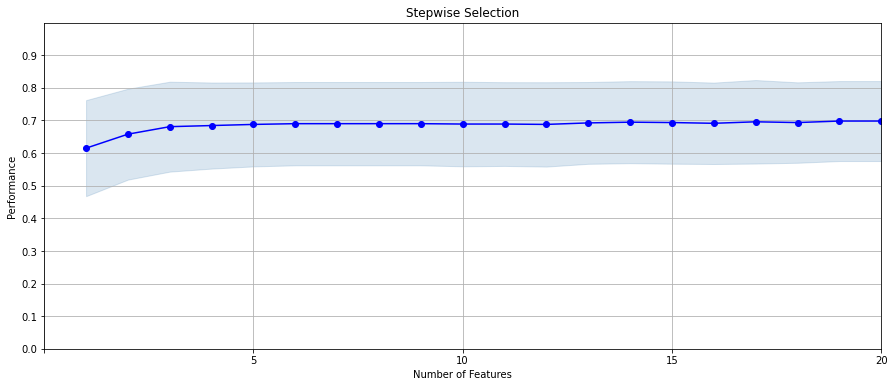

In [18]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('FS_fdr.png')
plt.show()

In [19]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [20]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = list(ordered_vars_FS.loc[i+1,'feature_names'])[0]
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])

In [21]:
ordered_vars_FS

feature_idx  \
1                                                (2,)   
2                                             (2, 44)   
3                                          (2, 6, 44)   
4                                      (2, 6, 44, 79)   
5                                  (2, 6, 32, 44, 79)   
6                              (2, 6, 32, 44, 68, 79)   
7                          (2, 6, 32, 44, 62, 68, 79)   
8                      (2, 6, 32, 44, 62, 68, 74, 79)   
9                  (2, 6, 32, 44, 62, 68, 74, 75, 79)   
10             (2, 6, 30, 32, 44, 62, 68, 74, 75, 79)   
11         (2, 6, 30, 32, 44, 62, 65, 68, 74, 75, 79)   
12     (2, 6, 25, 30, 32, 44, 62, 65, 68, 74, 75, 79)   
13  (2, 6, 25, 30, 32, 42, 44, 62, 65, 68, 74, 75,...   
14  (2, 6, 25, 30, 32, 42, 44, 62, 64, 65, 68, 74,...   
15  (2, 6, 25, 30, 32, 42, 44, 60, 62, 64, 65, 68,...   
16  (2, 6, 25, 29, 30, 32, 42, 44, 60, 62, 64, 65,...   
17  (2, 6, 25, 29, 30, 32, 42, 44, 60, 62, 64, 65,...   
18  (2, 6, 14, 25, 29, 30, 32, 42, 44, 60, 62, 64,...   
19  (2, 6, 14, 25, 29, 30, 32, 42, 44, 52, 60, 62,...   
20  (2, 6, 14, 25, 29, 30, 32, 42, 44, 52, 60, 62,...   

                                            cv_scores avg_score  \
1   [0.4482758620689655, 0.5632183908045977, 0.827...   0.61517   
2   [0.4942528735632184, 0.6206896551724138, 0.724...  0.658019   
3   [0.5632183908045977, 0.6091954022988506, 0.793...  0.681048   
4   [0.6206896551724138, 0.6091954022988506, 0.793...  0.684483   
5   [0.6206896551724138, 0.6091954022988506, 0.793...  0.687944   
6   [0.6436781609195402, 0.6091954022988506, 0.793...  0.690243   
7   [0.6436781609195402, 0.6091954022988506, 0.793...  0.690243   
8   [0.6436781609195402, 0.6091954022988506, 0.793...  0.690243   
9   [0.6436781609195402, 0.6091954022988506, 0.793...  0.690243   
10  [0.6436781609195402, 0.6091954022988506, 0.793...  0.689094   
11  [0.6436781609195402, 0.6091954022988506, 0.793...   0.68908   
12  [0.6206896551724138, 0.6091954022988506, 0.793...  0.687984   
13  [0.6436781609195402, 0.6551724137931034, 0.793...  0.692555   
14  [0.6436781609195402, 0.6551724137931034, 0.793...  0.694854   
15  [0.6436781609195402, 0.6436781609195402, 0.793...  0.693705   
16  [0.6206896551724138, 0.6436781609195402, 0.793...  0.691379   
17  [0.6436781609195402, 0.6551724137931034, 0.793...  0.695977   
18  [0.6091954022988506, 0.6551724137931034, 0.793...  0.693651   
19  [0.6206896551724138, 0.6781609195402298, 0.793...  0.698276   
20  [0.6206896551724138, 0.6781609195402298, 0.793...  0.698276   

                                        feature_names  ci_bound   std_dev  \
1                                 (card_zip_total_3,)  0.109339  0.147216   
2               (card_zip_total_3, card_state_max_30)   0.10348  0.139328   
3   (card_zip_total_3, card_zip_total_14, card_sta...  0.102395  0.137866   
4   (card_zip_total_3, card_zip_total_14, card_sta...  0.098007  0.131958   
5   (card_zip_total_3, card_zip_total_14, card_zip...    0.0956  0.128717   
6   (card_zip_total_3, card_zip_total_14, card_zip...  0.094842  0.127696   
7   (card_zip_total_3, card_zip_total_14, card_zip...  0.094842  0.127696   
8   (card_zip_total_3, card_zip_total_14, card_zip...  0.094842  0.127696   
9   (card_zip_total_3, card_zip_total_14, card_zip...  0.094842  0.127696   
10  (card_zip_total_3, card_zip_total_14, card_sta...  0.096253  0.129596   
11  (card_zip_total_3, card_zip_total_14, card_sta...   0.09534  0.128367   
12  (card_zip_total_3, card_zip_total_14, card_sta...  0.096057  0.129333   
13  (card_zip_total_3, card_zip_total_14, card_sta...  0.093137  0.125401   
14  (card_zip_total_3, card_zip_total_14, card_sta...  0.093394  0.125748   
15  (card_zip_total_3, card_zip_total_14, card_sta...  0.093698  0.126157   
16  (card_zip_total_3, card_zip_total_14, card_sta...  0.092697  0.124808   
17  (card_zip_total_3, card_zip_total_14, card_sta...  0.095072  0.128007   
18  (card_zip_total_3, card_zip_total_14, card_zip

In [22]:
ordered_vars_FS.to_csv('VarsFS.csv', index=False)

In [23]:
ordered_vars_FS['variable name']

1       card_zip_total_3
2      card_state_max_30
3      card_zip_total_14
4       card_state_avg_0
5       card_zip_total_0
6       card_merch_avg_1
7         card_zip_avg_1
8       card_merch_avg_0
9         card_zip_avg_0
10    card_state_total_0
11        Merchnum_avg_0
12     card_state_max_14
13       Cardnum_total_7
14       merch_zip_avg_0
15      card_state_avg_1
16    card_merch_total_0
17     merch_zip_total_0
18        card_zip_max_7
19     merch_state_max_1
20        Merchnum_avg_1
Name: variable name, dtype: object

In [24]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)

In [25]:
vars_keep

1       card_zip_total_3
2      card_state_max_30
3      card_zip_total_14
4       card_state_avg_0
5       card_zip_total_0
6       card_merch_avg_1
7         card_zip_avg_1
8       card_merch_avg_0
9         card_zip_avg_0
10    card_state_total_0
11        Merchnum_avg_0
12     card_state_max_14
13       Cardnum_total_7
14       merch_zip_avg_0
15      card_state_avg_1
16    card_merch_total_0
17     merch_zip_total_0
18        card_zip_max_7
19     merch_state_max_1
20        Merchnum_avg_1
Name: variable name, dtype: object

In [26]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['card_zip_total_3',
 'card_state_max_30',
 'card_zip_total_14',
 'card_state_avg_0',
 'card_zip_total_0',
 'card_merch_avg_1',
 'card_zip_avg_1',
 'card_merch_avg_0',
 'card_zip_avg_0',
 'card_state_total_0',
 'Merchnum_avg_0',
 'card_state_max_14',
 'Cardnum_total_7',
 'merch_zip_avg_0',
 'card_state_avg_1',
 'card_merch_total_0',
 'merch_zip_total_0',
 'card_zip_max_7',
 'merch_state_max_1',
 'Merchnum_avg_1',
 'Recnum',
 'Fraud']

In [27]:
df = pd.read_csv(file_name)

In [28]:
df_keep = df.filter(vars_keep_list, axis=1)
print(df_keep.shape)

(96397, 22)


In [29]:
df_keep.to_csv('vars_final.csv',index=False)

In [32]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:19:55.659272
